# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [4]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [8]:
import re

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SimpleRNN
from keras.models import Model
from tensorflow.keras.layers import Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.layers import Input

In [9]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('data_volunteers.json', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
    output = 'data_volunteers.json'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [10]:
# dataset_file
import json

text_file = "data_volunteers.json"
with open(text_file) as f:
    data = json.load(f) # la variable data será un diccionario



In [11]:
# Observar los campos disponibles en cada linea del dataset
data[0].keys()

dict_keys(['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id'])

In [13]:
import re
chat_in = []
chat_out = []

input_sentences = []
output_sentences = []
output_sentences_inputs = []
max_len = 30

def clean_text(txt):
    txt = txt.lower()
    txt = re.sub(r"'d", " had", txt)
    txt = re.sub(r"'s", " is", txt)
    txt = re.sub(r"'m", " am", txt)
    txt = re.sub(r"'ve", " have", txt)
    txt = re.sub(r"'don't", "do not", txt)
    txt = re.sub(r'\W+', ' ', txt)
    
    return txt

for line in data:
    for i in range(len(line['dialog'])-1):
        # vamos separando el texto en "preguntas" (chat_in)
        # y "respuestas" (chat_out)
        chat_in = clean_text(line['dialog'][i]['text'])
        chat_out = clean_text(line['dialog'][i+1]['text'])

        if len(chat_in) >= max_len or len(chat_out) >= max_len:
            continue

        input_sentence, output = chat_in, chat_out
        
        # output sentence (decoder_output) tiene <eos>
        output_sentence = output + ' <eos>'
        # output sentence input (decoder_input) tiene <sos>
        output_sentence_input = '<sos> ' + output

        input_sentences.append(input_sentence)
        output_sentences.append(output_sentence)
        output_sentences_inputs.append(output_sentence_input)

print("Cantidad de rows utilizadas:", len(input_sentences))

Cantidad de rows utilizadas: 5976


In [14]:
input_sentences[1], output_sentences[1], output_sentences_inputs[1]

('hi how are you ', 'not bad and you  <eos>', '<sos> not bad and you ')

### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [16]:
MAX_VOCAB_SIZE = 8000

In [17]:
# tokenizador de preguntas
input_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
input_tokenizer.fit_on_texts(input_sentences)
input_integer_seq = input_tokenizer.texts_to_sequences(input_sentences)

word2idx_inputs = input_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_inputs))

max_input_len = max(len(sen) for sen in input_integer_seq)
print("Sentencia de entrada más larga:", max_input_len)

Palabras en el vocabulario: 1773
Sentencia de entrada más larga: 9


In [18]:
# tokenizador de respuestas
# Se saca los "<>" para que no afectar nuestros tokens
output_tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='!"#$%&()*+-/:;=@[\\]^_`{|}~\t\n')
output_tokenizer.fit_on_texts(["<sos>", "<eos>"] + output_sentences)
output_integer_seq = output_tokenizer.texts_to_sequences(output_sentences)
output_input_integer_seq = output_tokenizer.texts_to_sequences(output_sentences_inputs)

word2idx_outputs = output_tokenizer.word_index
print("Palabras en el vocabulario:", len(word2idx_outputs))

num_words_output = min(len(word2idx_outputs) + 1, MAX_VOCAB_SIZE) 


max_out_len = max(len(sen) for sen in output_integer_seq)
print("Sentencia de salida más larga:", max_out_len)

Palabras en el vocabulario: 1788
Sentencia de salida más larga: 10


In [19]:
print("Cantidad de rows del dataset:", len(input_integer_seq))

encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences shape:", encoder_input_sequences.shape)

decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences shape:", decoder_input_sequences.shape)

Cantidad de rows del dataset: 5976
encoder_input_sequences shape: (5976, 9)
decoder_input_sequences shape: (5976, 10)


In [20]:
from keras.utils import to_categorical
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
decoder_targets = to_categorical(decoder_output_sequences, num_classes=num_words_output)
decoder_targets.shape

(5976, 10, 1789)

### 3 - Preparar los embeddings
Se utilizan los embeddings de Glove para transformar los tokens de entrada en vectores

In [21]:
import os
import gdown
if os.access('gloveembedding.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KY6avD5I1eI2dxQzMkR3WExwKwRq2g94&export=download'
    output = 'gloveembedding.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings gloveembedding.pkl ya están descargados")

Los embeddings gloveembedding.pkl ya están descargados


In [22]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        index = np.arange(self.embeddings.shape[0])
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60

In [24]:
model_embeddings = GloveEmbeddings()

In [25]:
print('preparing embedding matrix...')
embed_dim = model_embeddings.N_FEATURES
words_not_found = []

nb_words = min(MAX_VOCAB_SIZE, len(word2idx_inputs)) # vocab_size
print("nb_words: " + str(nb_words))
embedding_matrix = np.zeros((nb_words + 1, embed_dim))
for word, i in word2idx_inputs.items():
    if i >= nb_words:
        continue
    embedding_vector = model_embeddings.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
nb_words: 1773
number of null word embeddings: 39


In [26]:
embedding_matrix.shape

(1774, 50)

### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [27]:
max_input_len

9

In [30]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense

n_units = 128

encoder_inputs = Input(shape=(max_input_len,))

encoder_embedding_layer = Embedding(
          input_dim=nb_words + 1,  
          output_dim=embed_dim,  
          input_length=max_input_len, 
          weights=[embedding_matrix],  
          trainable=False)     

encoder_inputs_x = encoder_embedding_layer(encoder_inputs)

encoder = LSTM(n_units, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs_x)
encoder_states = [state_h, state_c]

# define training decoder
decoder_inputs = Input(shape=(max_out_len,))
decoder_embedding_layer = Embedding(input_dim=num_words_output, output_dim=n_units, input_length=max_out_len)
decoder_inputs_x = decoder_embedding_layer(decoder_inputs)

decoder_lstm = LSTM(n_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs_x, initial_state=encoder_states)

# Dense
decoder_dense = Dense(num_words_output, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer="Adam", metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_4       │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 9, 50)     │     88,700 │ input_layer_3[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 10, 128)   │    228,992 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 128),     │     91,648 │ embedding_1[0][0] │
│                     │ (None, 128),      │            │                   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ [(None, 10, 128), │    131,584 │ embedding_2[0][0… │
│                     │ (None, 128),      │            │ lstm_1[0][1],     │
│                     │ (None, 128)]      │            │ lstm_1[0][2]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10, 1789)  │    230,781 │ lstm_2[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 771,705 (2.94 MB)

 Trainable params: 683,005 (2.61 MB)

 Non-trainable params: 88,700 (346.48 KB)

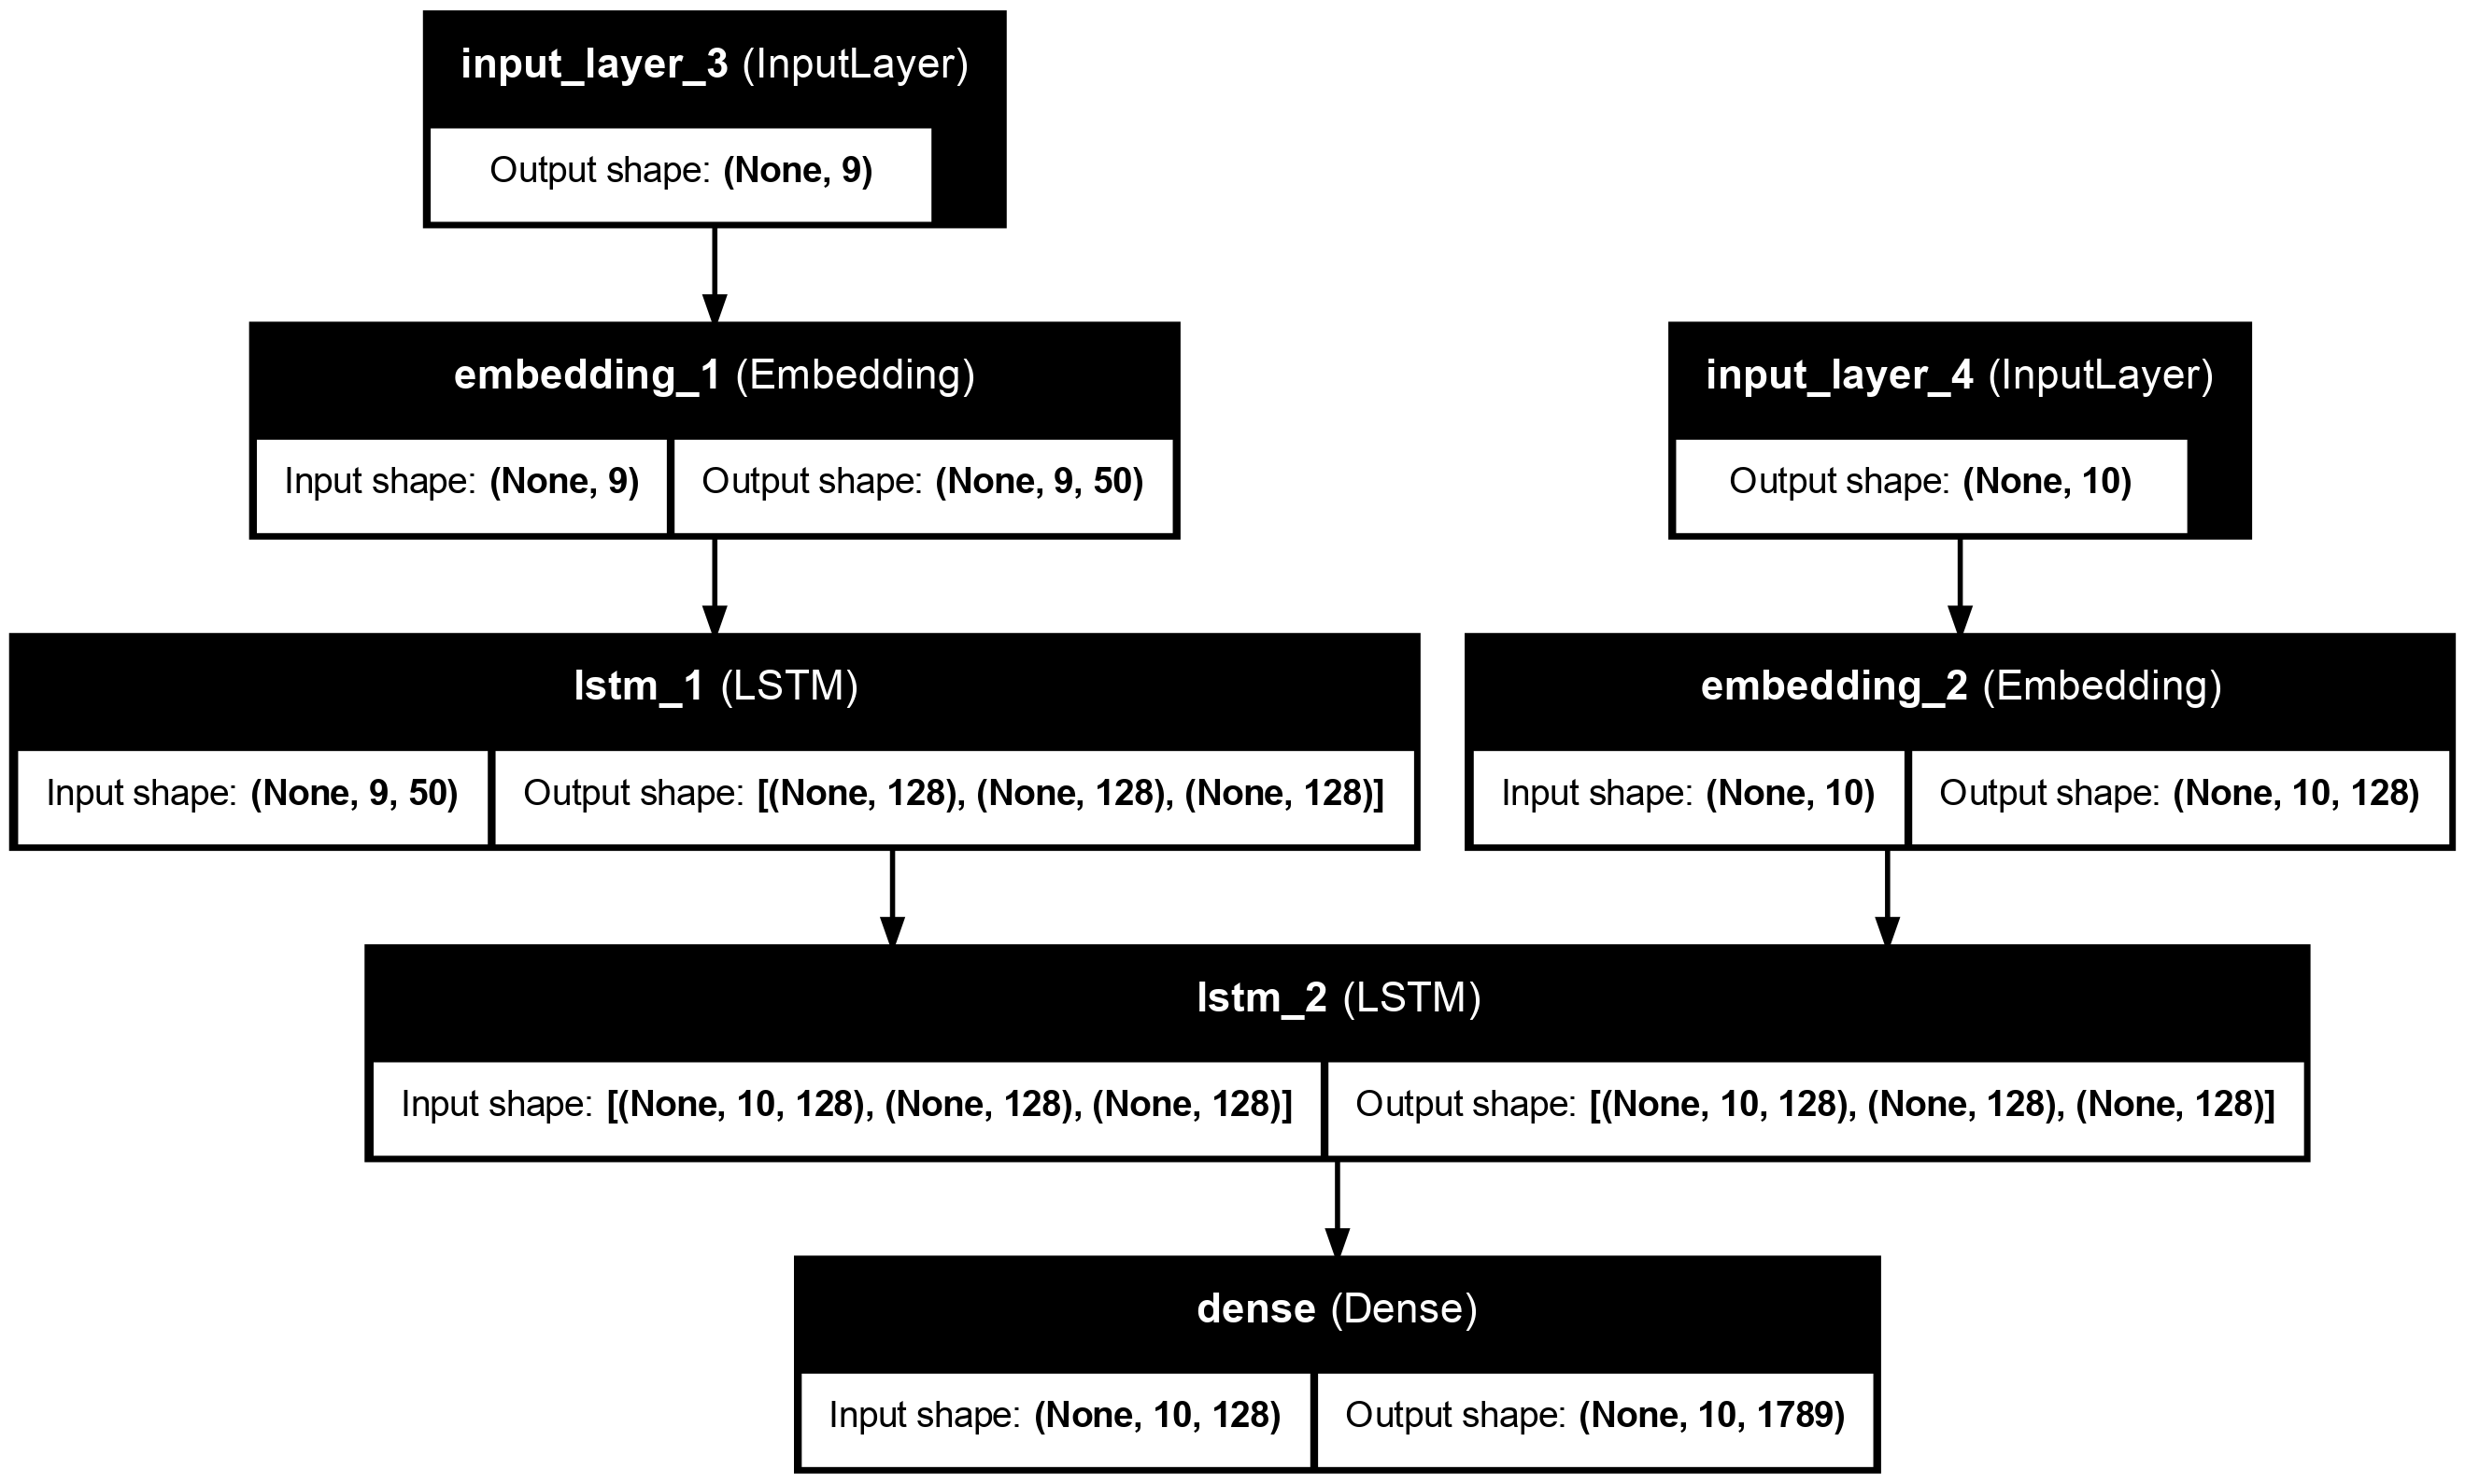

In [31]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

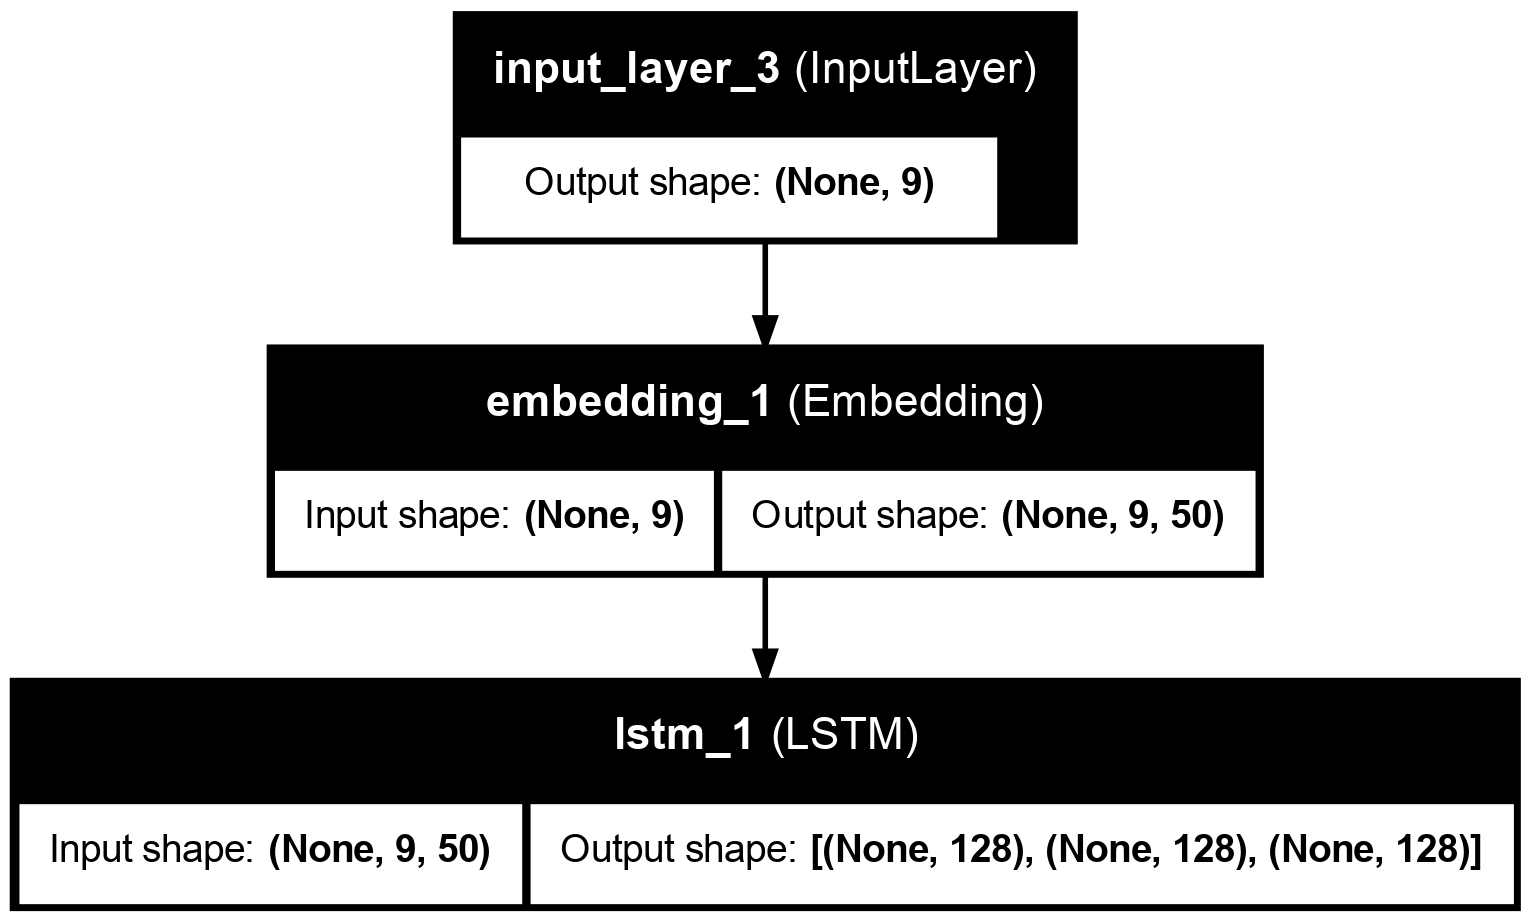

In [32]:
encoder_model = Model(encoder_inputs, encoder_states)

plot_model(encoder_model, to_file='encoder_plot.png', show_shapes=True, show_layer_names=True)

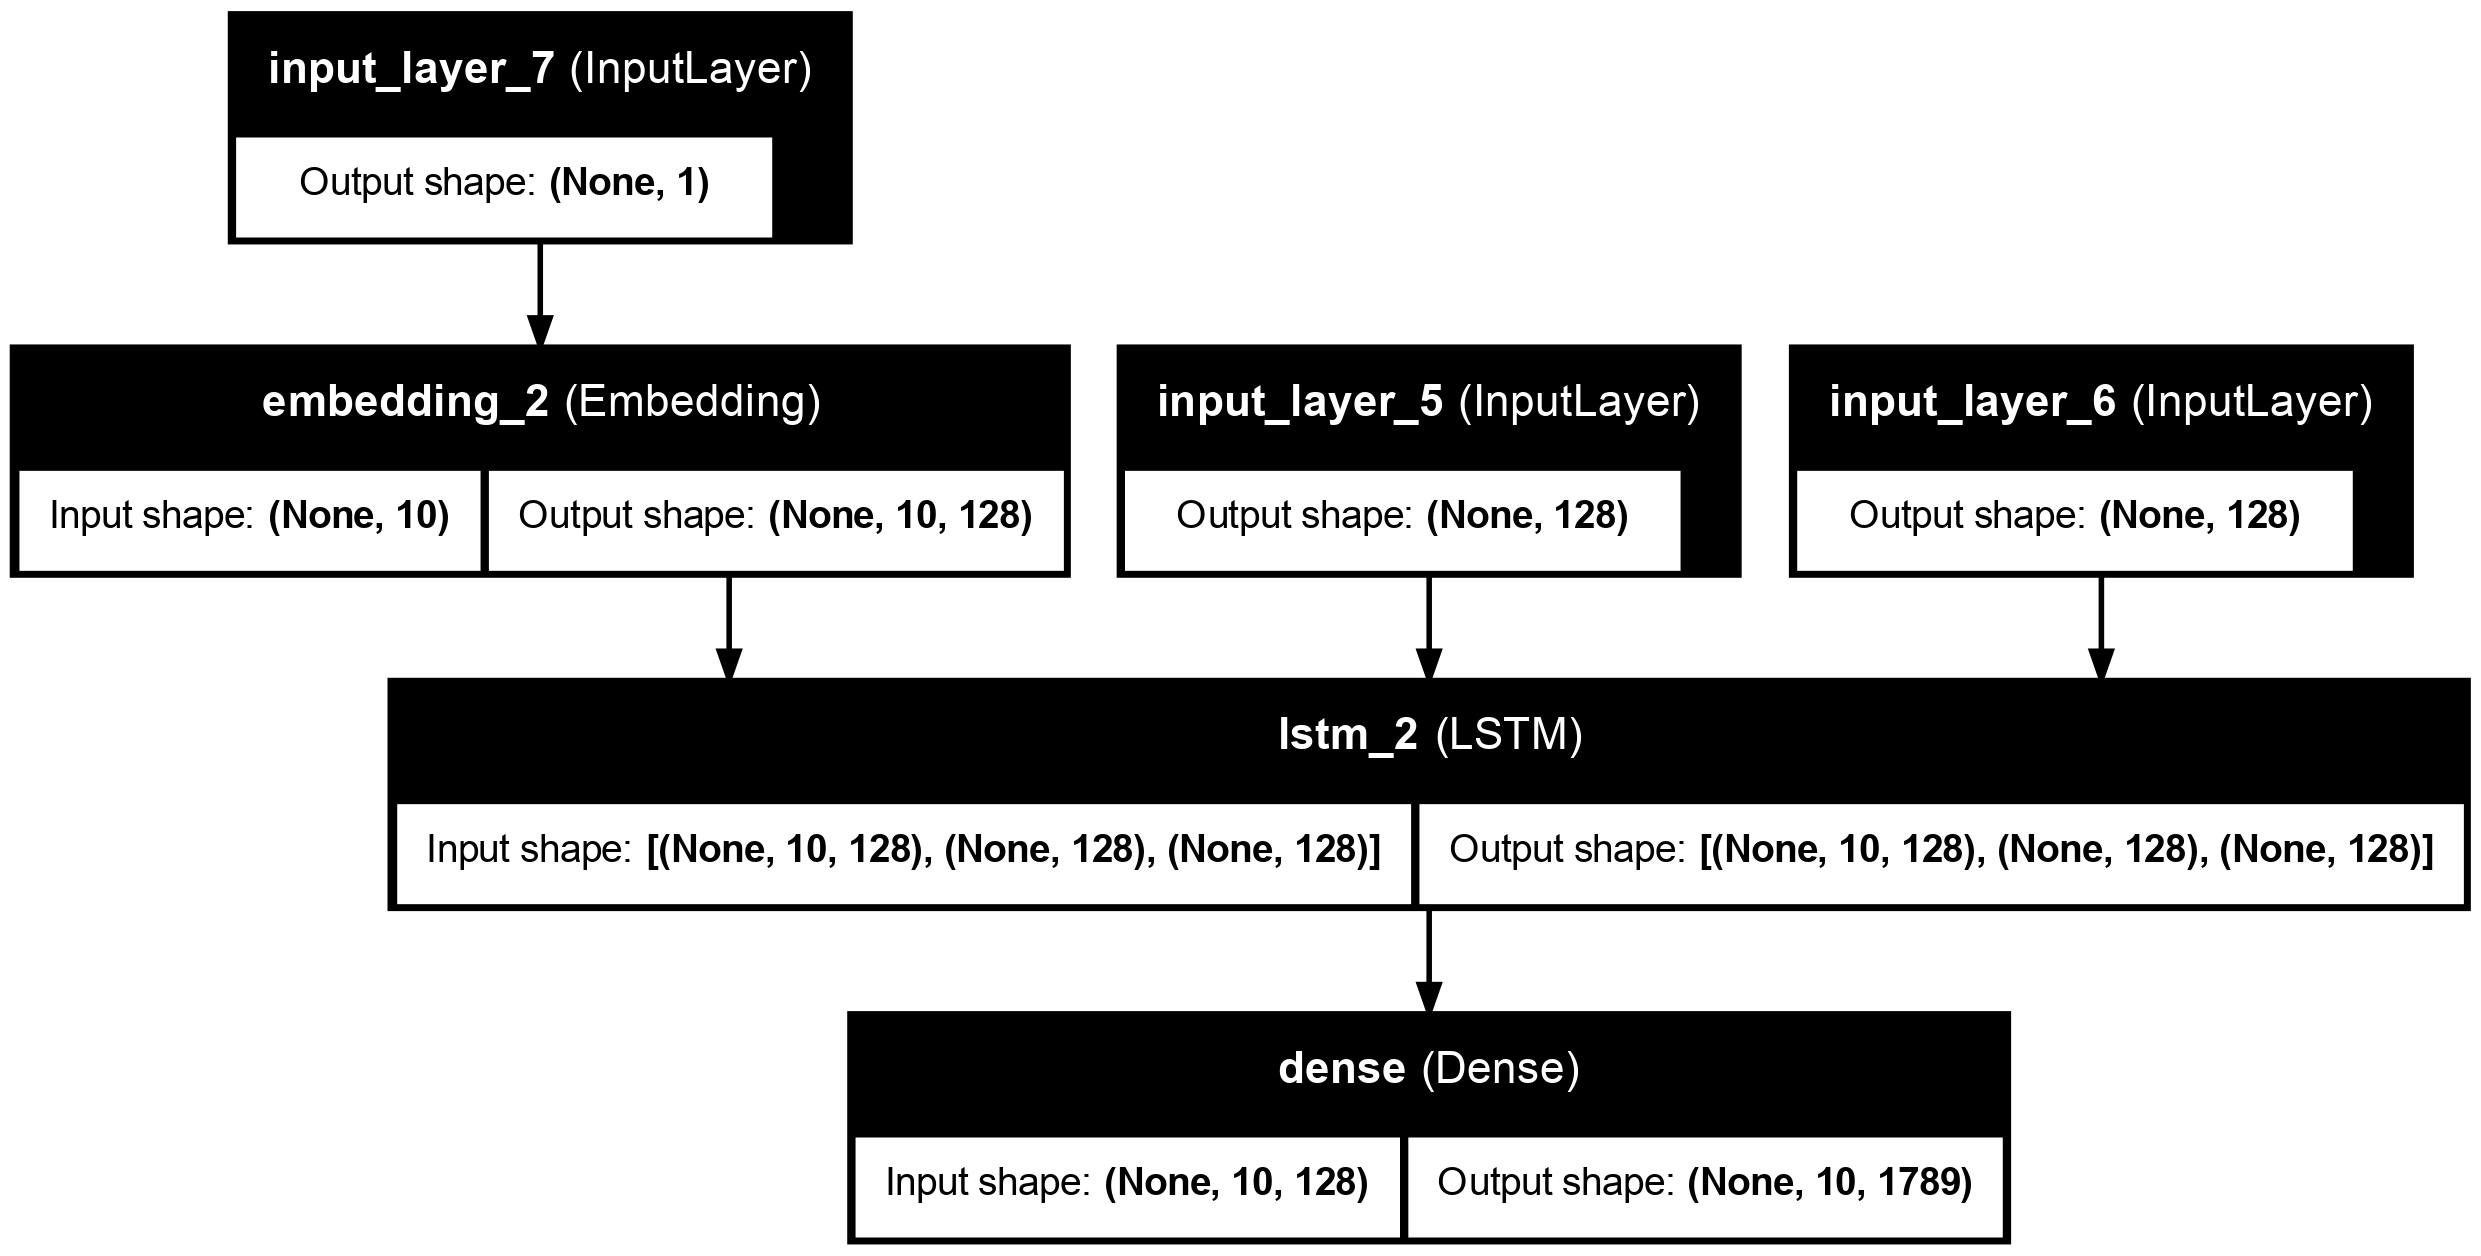

In [33]:
# define inference decoder
decoder_state_input_h = Input(shape=(n_units,))
decoder_state_input_c = Input(shape=(n_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# por lo que hay que modificar el input shape de la layer de Embedding
decoder_inputs_single = Input(shape=(1,))
decoder_inputs_single_x = decoder_embedding_layer(decoder_inputs_single)

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs_single] + decoder_states_inputs, [decoder_outputs] + decoder_states)

plot_model(decoder_model, to_file='decoder_plot.png', show_shapes=True, show_layer_names=True)

In [34]:
hist = model.fit(
    [encoder_input_sequences, decoder_input_sequences],
    decoder_targets,
    epochs=100, 
    validation_split=0.2)

Epoch 1/100


2024-07-01 13:20:54.229484: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5035 - loss: 4.1702 - val_accuracy: 0.6334 - val_loss: 2.1869
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6249 - loss: 2.0279 - val_accuracy: 0.6768 - val_loss: 2.0151
Epoch 3/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6887 - loss: 1.8011 - val_accuracy: 0.6970 - val_loss: 1.8892
Epoch 4/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7179 - loss: 1.6268 - val_accuracy: 0.7055 - val_loss: 1.8173
Epoch 5/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7310 - loss: 1.4992 - val_accuracy: 0.7125 - val_loss: 1.7629
Epoch 6/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7357 - loss: 1.4498 - val_accuracy: 0.7194 - val_loss: 1.7253
Epoch 7/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7451 - loss: 1.3789 - val_accuracy: 0.7235 - val_loss: 1.7004
Epoch 8/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7485 - loss: 1.3350 - val_accuracy: 0.7254

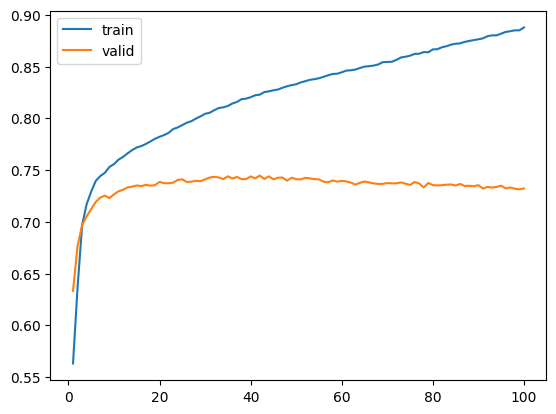

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

### 5 - Inferencia

In [36]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [40]:
def generate_answer(input_seq):
    states_value = encoder_model.predict(input_seq)

    # Se inicializa la secuencia de entrada al decoder como "<sos>"
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<sos>']

    # Se obtiene el índice que finaliza la inferencia
    eos = word2idx_outputs['<eos>']
    
    output_sentence = []
    for _ in range(max_out_len):
        # Predicción del próximo elemento
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        # Si es "end of sentece <eos>" se acaba
        if eos == idx:
            break

        # Transformar idx a palabra
        word = ''        
        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)

        # Actualizar los estados dada la última predicción
        states_value = [h, c]

        # Actualizar secuencia de entrada con la salida (re-alimentación)
        target_seq[0, 0] = idx

    return ' '.join(output_sentence)

In [41]:
i = np.random.choice(len(input_sentences))
input_seq = encoder_input_sequences[i:i+1]
answer = generate_answer(input_seq)
print('-')
print('Input:', input_sentences[i])
print('Response:', answer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
-
Input: oh okay 
Response: what do you do for a living


In [47]:
input_test = "The earth says hello"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
answer = generate_answer(encoder_sequence_test)
print('Response:', answer)

Input: The earth says hello
Representacion en vector de tokens de ids [25, 18]
Padding del vector: [[ 0  0  0  0  0  0  0 25 18]]
Input: The earth says hello
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Response: hello how are you


In [48]:
input_test = "Do you have pets?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
answer = generate_answer(encoder_sequence_test)
print('Response:', answer)

Input: Do you have pets?
Representacion en vector de tokens de ids [3, 2, 15, 64]
Padding del vector: [[ 0  0  0  0  0  3  2 15 64]]
Input: Do you have pets?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Response: i do not have any


In [49]:
input_test = "Do you have any pet?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
answer = generate_answer(encoder_sequence_test)
print('Response:', answer)

Input: Do you have any pet?
Representacion en vector de tokens de ids [3, 2, 15, 29, 272]
Padding del vector: [[  0   0   0   0   3   2  15  29 272]]
Input: Do you have any pet?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Response: no


In [50]:
input_test = "Do you read"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
answer = generate_answer(encoder_sequence_test)
print('Response:', answer)

Input: Do you read
Representacion en vector de tokens de ids [3, 2, 22]
Padding del vector: [[ 0  0  0  0  0  0  3  2 22]]
Input: Do you read
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Response: yes


In [51]:
input_test = "Where are you from?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
answer = generate_answer(encoder_sequence_test)
print('Response:', answer)

Input: Where are you from?
Representacion en vector de tokens de ids [49, 8, 2, 37]
Padding del vector: [[ 0  0  0  0  0 49  8  2 37]]
Input: Where are you from?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Response: i am from the united states


In [52]:
input_test = "Hi"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
answer = generate_answer(encoder_sequence_test)
print('Response:', answer)

Input: Hi
Representacion en vector de tokens de ids [12]
Padding del vector: [[ 0  0  0  0  0  0  0  0 12]]
Input: Hi
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Response: hello how are you


In [53]:
input_test = "Do you have cats?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
answer = generate_answer(encoder_sequence_test)
print('Response:', answer)

Input: Do you have cats?
Representacion en vector de tokens de ids [3, 2, 15, 184]
Padding del vector: [[  0   0   0   0   0   3   2  15 184]]
Input: Do you have cats?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Response: no i don t do you


In [54]:
input_test = "Do you like football?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
answer = generate_answer(encoder_sequence_test)
print('Response:', answer)

Input: Do you like football?
Representacion en vector de tokens de ids [3, 2, 13, 325]
Padding del vector: [[  0   0   0   0   0   3   2  13 325]]
Input: Do you like football?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Response: i do not like it


In [57]:
input_test = "What's do you do for living?"
print('Input:', input_test)
integer_seq_test = input_tokenizer.texts_to_sequences([input_test])[0]
print("Representacion en vector de tokens de ids", integer_seq_test)
encoder_sequence_test = pad_sequences([integer_seq_test], maxlen=max_input_len)
print("Padding del vector:", encoder_sequence_test)

print('Input:', input_test)
answer = generate_answer(encoder_sequence_test)
print('Response:', answer)

Input: What's do you do for living?
Representacion en vector de tokens de ids [3, 2, 3, 9, 14]
Padding del vector: [[ 0  0  0  0  3  2  3  9 14]]
Input: What's do you do for living?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Response: i do not know what to say


Se observa que, aunque la cantidad de datos de entrenamiento no es tan grande, las respuestas obtenidas son coherentes y aprendió los términos especiales de `<SOS>` y `<EOS>`.
